# IFSCube examples

This notebook contains some examples of the functionalities of the IFSCube package and the gmosdc class. We recommend following the examples in this notebook in conjuction with the IFSCube manual, as that document has far more detailed explanations.

We begin by importing relevant modules and loading the data cube as a *gmosdc* object. We are also setting the redshift for the data cube as 0.008.

In [1]:
import matplotlib.pyplot as plt
import ifscube.cubetools as ct
import numpy as np

# only necessary in the notebook
%matplotlib inline

mycube = ct.gmosdc('ngc3081_cube.fits', redshift=0.008, var_ext=2)

## Basic Functions

### Plotting the spectrum

You can plot the spectrum of any spaxel with the **plotspec** function. For this example we choose to plot the spectrum of the spaxel 2, 3 (x, y).

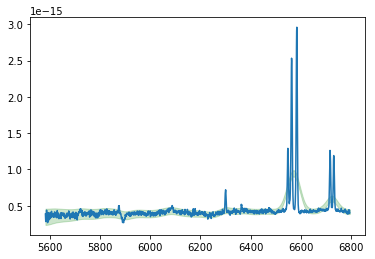

In [2]:
mycube.plotspec(2, 3)

It is also possible to plot the avarage spectrum of a group of spaxels. Just change the coordinates to any iterable variable, such as a list, with the starting and ending spaxel as the first and second elements. In the next example the avarage spectrum of the spaxels with $1 \le x < 3$ and $2 \le y < 5$ is plotted.

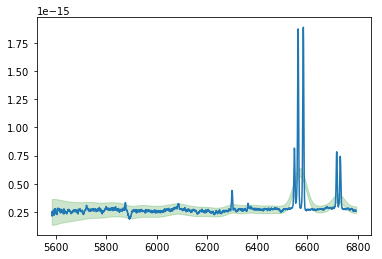

In [3]:
mycube.plotspec([1,3], [2,5])

### Image from wavelength cut

In order to get an image of the data cube at an specific wavelength you can use the **wlprojection** function.

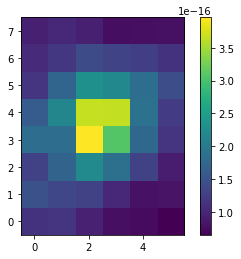

In [4]:
plt.imshow(mycube.wlprojection(6000, 100), origin='lower')
plt.colorbar()

## Spectral Fitting

We start by defining the initial guess $p_0$.

In [5]:
p0 = [
    1e-14,
    6584.0,
    3.0,
]

Next the complete call to fit the individual spectrum of the spaxel (3, 3), within the wavelengths 6450 and 6700.

In [6]:
myfit = mycube.linefit(
    p0, function='gaussian', fitting_window=(6450, 6700), individual_spec=(3, 3)
)

 0%


We can check the results by plotting the fit with the *plotfit* function. It takes as arguments the x and y coordinates of a spaxel. In this example, since we only fitted one spectrum, the spaxel has to be same one defined in the *individual_spec* argument.

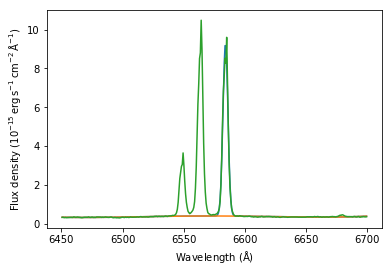

A         wl        s         
  8.90e-15   6584.18      2.03



In [7]:
mycube.plotfit(3, 3)

### Continuum fitting

The **linefit** function performs a continuum fit by default, if no specific option is given and if the continuum cube is not available (we will talk about a continuum cube later). You can change the continuum fitting options directly from the call to **linefit** by providing a dictionary to the *copts* argument. In the following example we will set a first order polynomial as the continuum function, and set it to 3 rejection iterations with sigma-clipping of 1 $\sigma$.

 0%


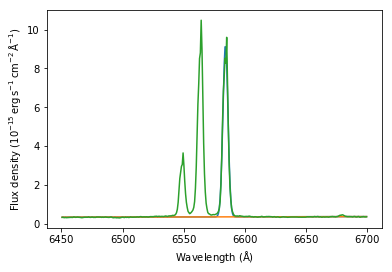

A         wl        s         
  8.88e-15   6584.17      2.06



In [8]:
continuum_options = dict(degr=1, niterate=3, lower_threshold=1, upper_threshold=1)

myfit = mycube.linefit(
    p0, function='gaussian', fitting_window=(6450, 6700), individual_spec=(3, 3),
    copts=continuum_options,
)

mycube.plotfit(3, 3)

### Fitting the whole cube

If we remove the *individual_spaxel* argument, then the fit will be applied to the whole cube. However, there are a few other options that might come in handy when fitting the whole cube, namely the *spiral_loop* and *spiral_center*. These arguments ensure that the fitting process starts in the center and moves outwards, from a good signal to noise spectrum to a bad one. Also, the *refit* option tells *linefit* to use the sucessful fits as a guide for the initial guess of future fits.

In [9]:
myfit = mycube.linefit(
    p0, function='gaussian', fitting_window=(6450, 6700), refit=True,
    spiral_loop=True, spiral_center=(2, 4), copts=continuum_options,
)

 0%


We can check the image of wavelengths, which is stored in the *em_model* attribute. In the example below we already converted the wavelength to velocities using

$$ v = \frac{\Delta \lambda}{\lambda} c $$

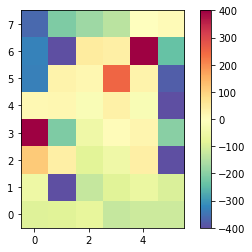

In [10]:
wl = mycube.em_model[1]
wl0 = 6584
v = (wl - wl0) / wl0 * 3e+5
plt.imshow(v, origin='lower', cmap='Spectral_r', vmin=-400, vmax=+400)
plt.colorbar()

That does not look good, let us check a few of the fits to see what went wrong. That (0, 2), for instance, is looking suspiciously low.

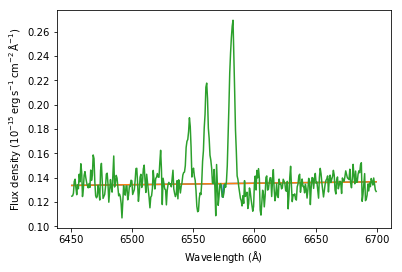

A         wl        s         
 -3.56e-17   6574.09      0.22



In [11]:
mycube.plotfit(1, 1)

Aha! It is completely wrong! The problem with our last fit was the lack of boundaries, to set what parameters are admissible. In order to limit the parameter space of the fit we define the *bounds* argument of *linefit* as a list of pairs, of minimum and maximum values, like the one below. Notice that you have to specify one pair for each parameter in $p_0$.

In [12]:
b = [
    [0, 1e-12],  # Flux
    [6580, 6590],  # Wavelength
    [1.5, 4],  # Sigma
]

Now let us try that with our previous fit example.

In [13]:
myfit = mycube.linefit(
    p0, function='gaussian', fitting_window=(6450, 6700), refit=True,
    spiral_loop=True, spiral_center=(2, 4), bounds=b)

 0%


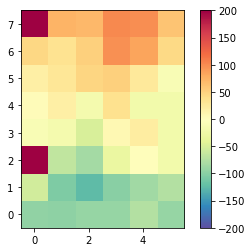

In [14]:
wl = mycube.em_model[1]
wl0 = 6584
v = (wl - wl0) / wl0 * 3e+5
plt.imshow(v, origin='lower', cmap='Spectral_r', vmin=-200, vmax=+200)
plt.colorbar()

Much better! There seems to be some problem yet with spaxels (0, 2) and (0, 7), but the rest of the cube seems pretty good, in the sense that a rotation pattern compatible with a disk galaxy is visible.

### Multiple lines

Next we will try to fit all the three emission lines at once. In order to do that the only thing needed is to make an initial guess with Nx3 elements, where N is the number of desired components. For instance

In [15]:
p0 = [                                           
    1e-14,  # The flux at the center of the line.
    6548.0,  # The central wavelength.           
    3.0,  # The sigma in wavelength units.       
                                                 
    1e-14,  # The flux at the center of the line.
    6562.8,  # The central wavelength.           
    3.0,  # The sigma in wavelength units.       
                                                 
    1e-14,  # The flux at the center of the line.
    6584.,  # The central wavelength.           
    3.0,  # The sigma in wavelength units.       
    ]                                            


 0%


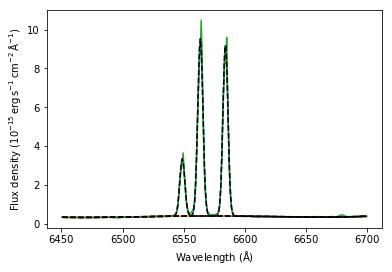

A         wl        s         
  2.95e-15   6548.90     -2.06
  9.14e-15   6563.64      2.10
  8.90e-15   6584.18      2.03



In [16]:
myfit = mycube.linefit(p0, function='gaussian', fitting_window=(6450, 6700), individual_spec=(3, 3))

mycube.plotfit(3, 3)